# Trabajo final Mineria y Analisis de Datos: ¿Qué tipo de viaje será?



<center>Eduardo Hidalgo García 000117037</center>

<p>*Competencia de Walmart en Kaggle*<p>

**Resúmen:** Mashable es una empresa global de multi-plataformas de información y entretenimiento digital.  Para este trabajo se obtuvieron datos de un conjunto de características acerca de artículos publicados por *Mashable* en el transcurso de dos años. El objetivo es predecir el numero de veces que un articulo se compartirá en las redes sociales. En términos más coloquiales, en este trabajo se tratará de medir la popularidad de un articulo (instrumentando por el número de veces que será compartido).  Para tal fin se comparán los resultados de tres modelos predictivos : *Random Forest*, *Máquina de soporte vectorial* y *K-vecinos cercanos*. Encontramos que el mejor nivel de *accuracy* lo obtiene el modelo de *Random Forest* de $512$ árboles  y una profuncidad de $16$ niveles de cada árbol con **$65$%** , seguido por la *Maquina de soporte vectorial* de kernel **RBF (Radial Basisi Function)** y parámetro de penalización al error igual a $2$ con **$62$%** y por último el modelo de *K-vecinos cercanos* cuando se definen los pesos de acuerdo a la distancia de cada instancia y se seleccionan 128 instancias con **$61$%**. Los datos se obtuvieron de la base de datos de la Universidad de California en Irvine  (http://archive.ics.uci.edu/ml/datasets/Online+News+Popularity).



In [1]:
%matplotlib inline
import pandas as pd
import sklearn.preprocessing as pre
import sklearn.model_selection as mo
import sklearn.ensemble as ens
import sklearn.linear_model as lin
import sklearn.tree as tree
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import sklearn.svm as svm
import sklearn.neighbors as neigh
import math
import numpy as np
import seaborn as sns



import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc, precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp


def MenosImportante(X, y, Xt, yt, modelo):
    maxa=0 #Max. accuracy
    maxi=0 #Max. index
    for i in range(len(X.keys())):
        #print( i, "/",len(X.keys()) , end="\r")
        aux=X.copy()
        aux2=aux.pop(X.keys()[i])
        modelo.fit(X, y)
        sc=modelo.score(Xt, yt)
        if maxa<sc:
            maxa=sc
            maxi=i
    return (X.keys()[maxi], maxa)
        
    
def MejorarNoticia(X, modelo):
    maxa=0 #Max. improvement
    maxi=0 #Max. index
    sign=0
    probi=mod.predict_proba(X)[0][1]
    for i in range(len(X.keys())):
        aux=X.copy()
        aux[X.keys()[i]]=aux[X.keys()[i]]+0.5
        prob=mod.predict_proba(aux)[0][1]-probi
        if prob>maxa:
            maxa=prob
            sign=+1
            maxi=i
        aux=X.copy()
        aux[X.keys()[i]]=aux[X.keys()[i]]-0.5
        prob=mod.predict_proba(aux)[0][1]-probi
        if prob>maxa:
            maxa=prob
            sign=-1
            maxi=i
            
    return (X.keys()[maxi], maxa, sign)

# 1 Introducción
<p>Para esta competencia, se tiene la tarea de **clasificar** los **tipos de viaje de compras en función de los artículos que compran los clientes**. Para dar algunos ejemplos hipotéticos de tipos de viaje: un cliente puede hacer un pequeño viaje diario para cenar, un viaje semanal de compras grandes, un viaje para comprar regalos para unas próximas vacaciones o un viaje de temporada para comprar ropa.</p>


<p>**Walmart ha categorizado los viajes** contenidos en estos datos **en 38 tipos distintos** utilizando un **método patentado** aplicado a un conjunto extendido de datos. Tiene el **desafío de recrear esta categorización / agrupamiento** con un conjunto de funciones más limitado. Esto podría proporcionar formas nuevas y más robustas para clasificar los viajes.</p>

<p>**El conjunto de entrenamiento (train.csv) contiene una gran cantidad de visitas de clientes con el TripType incluido. Debe predecir el TripType para cada visita de cliente en el conjunto de prueba (test.csv). Cada visita solo puede tener un TripType. No se le proporcionará más información que la que se proporciona en los datos (por ejemplo, qué representan los TripType o más información sobre el producto).</p>


Descripción de los campos de la data (Descripción en ingles de la página de **Kaggle**)

<p>TripType - a categorical id representing the type of shopping trip the customer made. This is the ground truth that you are predicting. TripType_999 is an "other" category.</p>
<p>VisitNumber - an id corresponding to a single trip by a single customer</p>
<p>Weekday - the weekday of the trip</p>
<p>Upc - the UPC number of the product purchased</p>
<p>ScanCount - the number of the given item that was purchased. A negative value indicates a product return.</p>
<p>DepartmentDescription - a high-level description of the item's department</p>
<p>FinelineNumber - a more refined category for each of the products, created by Walmart</p>

<p>La información se extrajo de la base de **Kaggle** y consolida información referente a las características del artículo comprado así como de las circustancias de su compra (ej: Día de la semana en que fue comprado, Codigo de Barras, Departamento al que pertenece, entre otras características para un total de 7). Para las predicciones finales se adoptó un enfoque de Clasificación (cada `TripType` es una categoría), probamos con tres distintos modelos depredicción: *Random Forest*, *Máquina de soporte vectorial* y *K-vecinos cercanos*. Además, previó al modelado buscamos optimizar la cantidad de variables a utlizar en el modelos mediante un *modelo de regresión decremental*</p>

# 2 Materiales y Métodos

## 2.1 Metodología

* **Selección de variable a predecir.-** Veremos si podemos encontrar modelos que predigan el número de de veces qeu se comparte un artículo (modelo de regresión) o en su defecto, que clasifiquen a los artículos en más compartidos y menos compartidos (modelo de clasificación). 

* **Selección de Modelo para filtrado de variables.-** Posteriormente, buscaremos someramente un buen modelo _baseline_ para hacer una selección de variables para incorporar en los modelos de predicción. 

* **Selección de variables independientes.-** Con base en el modelo _baseline_, haremos eliminación recursiva de variables. Luego graficaremos las pérdidas por cada variable que se quita para escoger la cantidad justa de variables que no sean demasiadas, y al mismo tiempo no perdamos poder predictivo. 

* **Selección de Hiper-parametros para los modelos de predicción.-** Posteriormente haremos una malla de hiperparámetros para tres distintos modelos, optimizaremos los tres y elegiremos un favorito. 

* **Evaluación de límite de clasificación.-** Finalmente evaluaremos distintos límites de clásificación, para el modelo con mayor accuracy, usando una curva ROC y también comparando el porcentaje de noticias clasificadas como populares bajo distintos thresholds con el porcentaje de predicciones correctas.

* Al final se detallan los resultados en la conclusión.


Durante todo este proceso nuestra métrica a optimizar y analizar será la precisión de las predicciones: es decir, el porcentaje de observaciones que fueron predichas correctamente. Lo anterior es porque:

* Un modelo con buen porcentaje de predicciones (mayor al mayor valor posible prediciendo la misma clase a todos las observaciones) sirve para la toma de decisiones

* Es una métrica fácil de entender y explicar. Si una junta directiva usara una métrica como el F1-score o el área bajo la curva ROC, es posible que miembros sin preparación técnica no lograran entender el modelo a profundidad. Por lo tanto, dado que nuestro modelo es aplicable, elegimos una métrica entendible a nivel general. 


## 2.2 Obtención de la información y Limpieza de la base

<p> De la base de datos de la Universidad de California en Irvine obtuvimos la sigueinte infromación. El  primero paso que seguimos fue limpiar la base de datos. La siguiente tabla, muestra la información tal como se recibió:

In [17]:
Base=pd.read_csv("dpt_per_visit.csv")
Base.head()

,VisitNumber,TripType,Weekday,tot_prods,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
0,5,999,Friday,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7,30,Friday,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0
2,8,26,Friday,32,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9,8,Friday,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10,8,Friday,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
Base.describe()

,VisitNumber,TripType,tot_prods,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
count,95674.000000,95674.000000,95674.000000,95674.000000,95674.000000,95674.000000,95674.000000,95674.000000,95674.000000,95674.000000,...,95674.000000,95674.000000,95674.000000,95674.000000,95674.000000,95674.000000,95674.000000,95674.000000,95674.000000,95674.000000
mean,95664.291187,108.699260,7.853628,0.002287,0.002391,0.013777,0.012483,0.005636,0.020662,0.003987,...,0.001686,0.000040,0.023035,0.000811,0.012088,0.003209,0.011686,0.001264,0.011717,0.007631
std,55238.991769,277.343017,10.256286,0.045590,0.035180,0.097310,0.077900,0.050346,0.097228,0.046394,...,0.022121,0.003311,0.118470,0.019824,0.081087,0.038077,0.087312,0.025814,0.083812,0.079494
min,5.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47992.250000,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,95818.500000,25.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,143432.750000,39.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,191347.000000,999.000000,315.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Para los modelos de predicción es necesario trabajar únicamente con variables de los tipos:
* Binarias
* Flotantes o dobles
* Enteros
A continuación se revisa el tipo de variables de la base original.

Por lo tanto, primero imprimiremos el tipo de cada variable y haremos las transformaciónes pertinentes

In [19]:
pd.options.display.max_rows = 999
Base.dtypes

VisitNumber                      int64
TripType                         int64
Weekday                         object
tot_prods                        int64
1-HR PHOTO                     float64
ACCESSORIES                    float64
AUTOMOTIVE                     float64
BAKERY                         float64
BATH AND SHOWER                float64
BEAUTY                         float64
BEDDING                        float64
BOOKS AND MAGAZINES            float64
BOYS WEAR                      float64
BRAS & SHAPEWEAR               float64
CAMERAS AND SUPPLIES           float64
CANDY, TOBACCO, COOKIES        float64
CELEBRATION                    float64
COMM BREAD                     float64
CONCEPT STORES                 float64
COOK AND DINE                  float64
DAIRY                          float64
DSD GROCERY                    float64
ELECTRONICS                    float64
FABRICS AND CRAFTS             float64
FINANCIAL SERVICES             float64
FROZEN FOODS             

### Variables Objeto a Factores

In [20]:
def test_func(Base):
    """ Test Function for generating new value"""
    if Base['Weekday'] == 'Friday':
        return 1
    else:
        return 0
Base['Friday'] = Base.apply(test_func, axis=1)


def test_func(Base):
    """ Test Function for generating new value"""
    if Base['Weekday'] == 'Saturday':
        return 1
    else:
        return 0
Base['Saturday'] = Base.apply(test_func, axis=1)

def test_func(Base):
    """ Test Function for generating new value"""
    if Base['Weekday'] == 'Sunday':
        return 1
    else:
        return 0
Base['Sunday'] = Base.apply(test_func, axis=1)

def test_func(Base):
    """ Test Function for generating new value"""
    if Base['Weekday'] == 'Monday':
        return 1
    else:
        return 0
Base['Monday'] = Base.apply(test_func, axis=1)

def test_func(Base):
    """ Test Function for generating new value"""
    if Base['Weekday'] == 'Tuesday':
        return 1
    else:
        return 0
Base['Tuesday'] = Base.apply(test_func, axis=1)

def test_func(Base):
    """ Test Function for generating new value"""
    if Base['Weekday'] == 'Wednesday':
        return 1
    else:
        return 0
Base['Wednesday'] = Base.apply(test_func, axis=1)

def test_func(Base):
    """ Test Function for generating new value"""
    if Base['Weekday'] == 'Thursday':
        return 1
    else:
        return 0
Base['Thursday'] = Base.apply(test_func, axis=1)

def transWeek(x):
    if x== "Sunday":
        return 1
    if x == "Monday":
        return 2
    if x == "Tuesday":
        return 3
    if x == "Wednesday":
        return 4
    if x == "Thursday":
        return 5
    if x == "Friday":
        return 6
    if x == "Saturday":
        return 7

Base['TransWeekday'] = Base['Weekday'].apply(transWeek)
Base.TransWeekday
#Base.TransWeekday[3]

In [21]:
Base.head()

,VisitNumber,TripType,Weekday,tot_prods,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,...,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS,Friday,Saturday,Sunday,Monday,Tuesday,Wednesday,Thursday
0,5,999,Friday,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,0,0,0,0,0,0
1,7,30,Friday,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,0,0,0,0,0,0
2,8,26,Friday,32,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,0,0,0,0,0,0
3,9,8,Friday,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,0,0,0,0,0,0
4,10,8,Friday,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,0,0,0,0,0,0


In [22]:
pd.options.display.max_rows = 999
Base.dtypes

VisitNumber                      int64
TripType                         int64
Weekday                         object
tot_prods                        int64
1-HR PHOTO                     float64
ACCESSORIES                    float64
AUTOMOTIVE                     float64
BAKERY                         float64
BATH AND SHOWER                float64
BEAUTY                         float64
BEDDING                        float64
BOOKS AND MAGAZINES            float64
BOYS WEAR                      float64
BRAS & SHAPEWEAR               float64
CAMERAS AND SUPPLIES           float64
CANDY, TOBACCO, COOKIES        float64
CELEBRATION                    float64
COMM BREAD                     float64
CONCEPT STORES                 float64
COOK AND DINE                  float64
DAIRY                          float64
DSD GROCERY                    float64
ELECTRONICS                    float64
FABRICS AND CRAFTS             float64
FINANCIAL SERVICES             float64
FROZEN FOODS             

In [23]:
Base_Modelaje = Base
del Base_Modelaje['Weekday']

<p>En este momento ya contamos con una replica categorica para cada variable string: </p>
* Weekday $\rightarrow$ TransWeekday 
* DepartmentDescription $\rightarrow$ TransDept
* Return $\rightarrow$ CatReturn
* ReturnVisit $\rightarrow$ CatReturnVisit
* VisitClass $\rightarrow$ CatTripClass

Generamos una copia de la base original `train_clean.csv` pero solo con las variables en el formato que necesitamos para la etapa de modelaje

In [24]:
Base_Modelaje.head()

,VisitNumber,TripType,tot_prods,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,...,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS,Friday,Saturday,Sunday,Monday,Tuesday,Wednesday,Thursday
0,5,999,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,0,0,0,0,0,0
1,7,30,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,0,0,0,0,0,0
2,8,26,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,0,0,0,0,0,0
3,9,8,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,0,0,0,0,0,0
4,10,8,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,0,0,0,0,0,0


In [25]:
pd.options.display.max_rows = 999
Base_Modelaje.dtypes

VisitNumber                      int64
TripType                         int64
tot_prods                        int64
1-HR PHOTO                     float64
ACCESSORIES                    float64
AUTOMOTIVE                     float64
BAKERY                         float64
BATH AND SHOWER                float64
BEAUTY                         float64
BEDDING                        float64
BOOKS AND MAGAZINES            float64
BOYS WEAR                      float64
BRAS & SHAPEWEAR               float64
CAMERAS AND SUPPLIES           float64
CANDY, TOBACCO, COOKIES        float64
CELEBRATION                    float64
COMM BREAD                     float64
CONCEPT STORES                 float64
COOK AND DINE                  float64
DAIRY                          float64
DSD GROCERY                    float64
ELECTRONICS                    float64
FABRICS AND CRAFTS             float64
FINANCIAL SERVICES             float64
FROZEN FOODS                   float64
FURNITURE                

A continuación, dividiremos la base en variables independientes y la variable dependiente. Posteriormente, subdividiremos en conjunto de entrenamiento y conjunto de prueba.  

In [26]:
Y=Base_Modelaje.pop('TripType')
X=Base_Modelaje.copy()
Xtrain,Xtest,Ytrain, Ytest = mo.train_test_split(X, Y, random_state=555953)

A continuación, normalizaremos la base de datos de variables independientes.

In [27]:
stand=pre.StandardScaler()
stand.fit(Xtrain)
Xtrainst=pd.DataFrame(stand.transform(Xtrain), columns=Xtrain.keys())
Xtestst=pd.DataFrame(stand.transform(Xtest), columns=Xtrain.keys())

# 3 Selección y Evaluación del modelo de predicción

## 3.1 Selección de Variables

Haremos un modelo de regresión decremental para la selección de variables donde iremos quitando la variable que menos ayude al análisis sucesivamente hasta reducir la cantidad de atributos que tenemos. Antes de emprender esto, averiguaremos qué modelo es el que mejor funciona con las variables como están ahora. Con base en ese modelo, podremos hacer selección de variables.

En esta sección, volveremos a partir nuestro training set en un "mini"training set, y un "mini" test set. Así, podremos probar algoritmos para la selección de variables con datos no vistos, que no sean del verdadero test set.



### Hiper-parámetos del modelo _baseline_

Probaremos el accuracy de un modelo _baseline_ bajo distintos hiper-parámetros y posteriormente lo utilizaremos para la regresión decremental que nos permitirá seleccionar las variables qué mas información aporten a la predicción del `TripType` 

In [28]:
Xtraintemp,Xtesttemp,Ytraintemp, Ytesttemp = mo.train_test_split(Xtrainst, Ytrain, random_state=555953)
accuracies=[]
i=0
for depth in [1, 2, 4, 8, 16, 32]:
    accuracies.append([])
    for nest in [1, 2, 4, 8, 16, 32]:
        print("depth=", depth, " nest=", nest, end="\r")
        mod=ens.RandomForestClassifier(n_estimators=nest, max_depth=depth)
        mod.fit(Xtraintemp,Ytraintemp)
        accuracies[i].append(mod.score(Xtesttemp,Ytesttemp))
    i=i+1


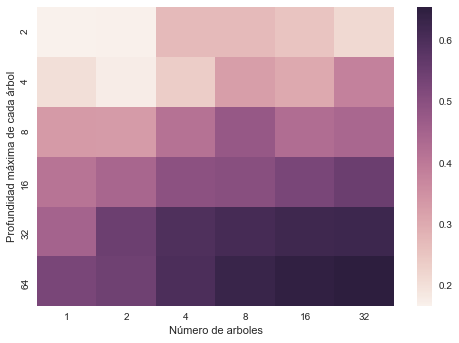

In [32]:
ax = sns.heatmap(accuracies, yticklabels=[1, 2, 4, 8, 16, 32, 64],  xticklabels=[1, 2, 4, 8, 16, 32, 64])
ax.set(xlabel='Número de arboles', ylabel='Profundidad máxima de cada árbol')

En el mapa de calor de arriba se sugiere que la mejor precisión se obtiene con una profundida de 64  o 32 nodos, y un número de estimadores o arboles entre 64 y 32. 

Ahora, podremos hacer nuestro método de eliminación recursiva de variables. Lo ideal, sería correr ese programa con el modelo ideal visto arriba. Esto porque finalmente buscaremos las mejores variables para el mejor modelo. Sin embargo, supondremos que la base tiene cierta "monotonicidad". Esto es, que para distintos híperparámetros (peores o mejores), las variables más importantes son las mismas. Por lo tanto, optimizaremos con una combinación no mala como sería depth=1 y n_estimators=1, pero tampoco idea como las primeras mencionadas ya que tardaría bastante. Nos decidimos por depth=32, y número de nodos=16.

## 3.2 Eliminación recursiva de variables

Usaremos el modelo _baseline_ decidido arriba para ir quitando variables recursivamente. Nuestra función corre el modelo baseline quitando una variable a la vez y devuelve la variable que menos disminuyo el accuracy rate al ser removida. El ciclo programado abajo hace esto recursivamente hasta que quedan cinco variables. Así podemos ver cuál es la máxima precisión limitando cada vez más el número de variables

In [31]:
Xtraintemp,Xtesttemp,Ytraintemp, Ytesttemp = mo.train_test_split(Xtrainst, Ytrain, random_state=555953)
#Ytraintemp=(Ytraintemp>1500)
#Ytesttemp=(Ytesttemp>1500)
mod=ens.RandomForestClassifier(n_estimators=4, max_depth=4, random_state=555953)
menos_importantes=[]
precisiones=[]
XTRT=Xtraintemp.copy()
YTRT=Ytraintemp.copy()
XTTT=Xtesttemp.copy()
YTTT=Ytesttemp.copy()
for j in range(len(XTRT.keys())-5):
    mine, maxa=MenosImportante(XTRT, YTRT,XTTT, YTTT , mod)
    menos_importantes.append(mine)
    precisiones.append(maxa)
    aux=XTRT.pop(mine)
    aux=XTTT.pop(mine)
    

In [33]:
precisiones

[0.39009978259657729,
 0.39600869613690842,
 0.36479179441440435,
 0.38831595964100563,
 0.29984948993812366,
 0.34020848430793243,
 0.33145660293215901,
 0.35397736774625116,
 0.35643012431016224,
 0.36518200568593567,
 0.3366408383967891,
 0.36250627125257817,
 0.37097943029154357,
 0.28998271921511792,
 0.34472378616422322,
 0.37493728747421817,
 0.36691008417414572,
 0.29566865488600258,
 0.36674285077206087,
 0.36111265956853783,
 0.35905011427615807,
 0.36122414850326107,
 0.3628964825241095,
 0.31908133117788062,
 0.32761023468420758,
 0.33390935949607004,
 0.33781147221138302,
 0.31150008361670106,
 0.31835665310217959,
 0.34249400746975861,
 0.31484475165839793,
 0.34645186465243327,
 0.26450749763086012,
 0.29628184402698032,
 0.34438931936005351,
 0.32777746808629243,
 0.3408774179162718,
 0.29940353419923071,
 0.29037293048664919,
 0.32320642176264008,
 0.33140085846479739,
 0.31707453035286248,
 0.2674062099336641,
 0.30113161268744076,
 0.32627236746752886,
 0.33195830313

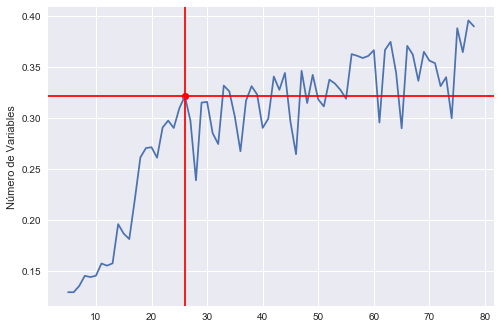

In [34]:
ticks=[]
for j in range(len(Xtraintemp.keys())-5):
    ticks.append(len(Xtraintemp.keys())-1-j)

plt.plot(ticks,precisiones)
plt.ylabel('Precisión')
plt.ylabel('Número de Variables')
plt.scatter(ticks[52], precisiones[52], color='red')
#plt.xticks([10, 20,ticks[26], 30, 40, 50, 60] )
#plt.yticks([0.56, 0.58, 0.6, 0.62, precisiones[26], 1])
#plt.ylim(ymax=1)
plt.axvline(x=ticks[52], color='red')
plt.axhline(y=precisiones[52], color='red')

plt.show()


In [35]:
menos_importantes

['VisitNumber',
 'tot_prods',
 '1-HR PHOTO',
 'ACCESSORIES',
 'AUTOMOTIVE',
 'BAKERY',
 'BATH AND SHOWER',
 'BEAUTY',
 'BEDDING',
 'BOOKS AND MAGAZINES',
 'BOYS WEAR',
 'BRAS & SHAPEWEAR',
 'CAMERAS AND SUPPLIES',
 'CANDY, TOBACCO, COOKIES',
 'CELEBRATION',
 'COMM BREAD',
 'CONCEPT STORES',
 'COOK AND DINE',
 'DAIRY',
 'DSD GROCERY',
 'ELECTRONICS',
 'FABRICS AND CRAFTS',
 'FINANCIAL SERVICES',
 'FROZEN FOODS',
 'FURNITURE',
 'GIRLS WEAR, 4-6X  AND 7-14',
 'GROCERY DRY GOODS',
 'HARDWARE',
 'HEALTH AND BEAUTY AIDS',
 'HOME DECOR',
 'HOME MANAGEMENT',
 'HORTICULTURE AND ACCESS',
 'HOUSEHOLD CHEMICALS/SUPP',
 'HOUSEHOLD PAPER GOODS',
 'IMPULSE MERCHANDISE',
 'INFANT APPAREL',
 'INFANT CONSUMABLE HARDLINES',
 'JEWELRY AND SUNGLASSES',
 'LADIES SOCKS',
 'LADIESWEAR',
 'LARGE HOUSEHOLD GOODS',
 'LAWN AND GARDEN',
 'LIQUOR,WINE,BEER',
 'MEAT - FRESH & FROZEN',
 'MEDIA AND GAMING',
 'MENS WEAR',
 'MENSWEAR',
 'NULL',
 'OFFICE SUPPLIES',
 'OPTICAL - FRAMES',
 'OPTICAL - LENSES',
 'OTHER DEPART

**Hemos elegido quedarnos con las mejores 32 variables**, ya que la pérdida en la que incurrimos por perder el resto (24) es menor al 2.3% en la precisión. Sin embargo, perder cualquiera de estas 32 variables nos llevaría a perder, como mínimo, 3%. Para la operación de quitarlas, vemos que todas las variables (que ya tenemos ordenadas por importancia) antes de la 27 son prescindibles. Por lo tanto las quitaremos

In [36]:
xtrainsel=Xtrainst.copy()
Xteststsel=Xtestst.copy()
for j in range(51):
    aux=xtrainsel.pop(menos_importantes[j])
    aux=Xteststsel.pop(menos_importantes[j])
    

## 3.3 Modelado

Como hicimos antes, una vez más haremos grids de los hiperparámetros posibles, para ver cuál es la mejor elección en cada modelo; e incluso poderlos comparar. Elegimos tres modelos:

* Random forest
* Máquina de soporte vectorial
* K-vecinos más cercanos

Para cada uno elegimos dos parámetros que afinar y graficamos un mapa de calor que representa una malla con todas las combinaciones posibles. 

### Random forest

En este modelo, usaremos una malla donde comparamos el desempeño de sus predicciones para distintas profundidades máximas para cada árbol, y distinto número de estimadores (árboles). Elegiremos la combinación que arroje la mayor precisión.

[Text(33,0.5,'Profundidad máxima de cada árbol'),
 Text(0.5,15,'Número de estimadores')]

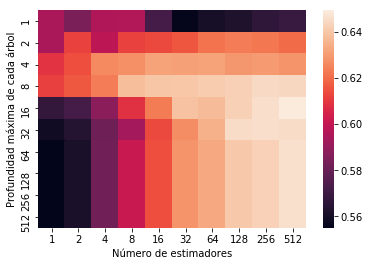

In [15]:
Xtraintemp,Xtesttemp,Ytraintemp, Ytesttemp = mo.train_test_split(xtrainsel, Ytrain, random_state=555953)
#Ytraintemp=(Ytraintemp>1500)
#Ytesttemp=(Ytesttemp>1500)
accuracies=[]
i=0
for depth in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]:
    accuracies.append([])
    for nest in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]:
        print("depth=", depth, " nest=", nest, end="\r")
        mod=ens.RandomForestClassifier(n_estimators=nest, max_depth=depth, random_state=555953)
        mod.fit(Xtraintemp,Ytraintemp)
        accuracies[i].append(mod.score(Xtesttemp,Ytesttemp))
    i=i+1
ax = sns.heatmap(accuracies, yticklabels=[1, 2, 4, 8, 16, 32, 64, 128, 256, 512],  xticklabels=[1, 2, 4, 8, 16, 32, 64, 128, 256, 512])
ax.set(xlabel='Número de estimadores', ylabel='Profundidad máxima de cada árbol')

Vemos que añadir profundidad más allá de 16 no ayuda. Por otro lado, vemos que el mejor número de estimadores es 512. Sugerimos que la mejor combinación es máxima profundidad=16 y máximo número de estimadores=512.

### Máquina de soporte vectorial

Ahora probaremos el desempeño de máquinas de soporte vectorial. En estos, decidimos variar el tipo de Kernel, y el parámetro de penalty del error. 

[Text(33,0.5,'C'), Text(0.5,15,'Kernel')]

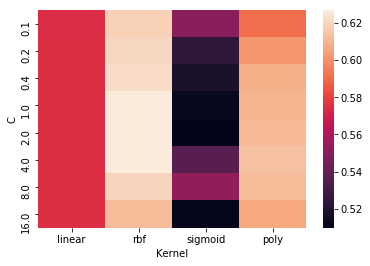

In [23]:
Xtraintemp,Xtesttemp,Ytraintemp, Ytesttemp = mo.train_test_split(xtrainsel, Ytrain, random_state=555953)
Ytraintemp=(Ytraintemp>1500)
Ytesttemp=(Ytesttemp>1500)
accuracies=[]
i=0
for C in [0.1, 0.2, 0.4, 1.0, 2.0, 4.0, 8.0, 16.0]:
    accuracies.append([])
    for kernel in ['linear', 'rbf', 'sigmoid', 'poly']:
        print("C=", C, " nest=", kernel, end="\r")
        mod=svm.SVC(C=C, kernel=kernel, random_state=555953)
        mod.fit(Xtraintemp,Ytraintemp)
        accuracies[i].append(mod.score(Xtesttemp,Ytesttemp))
    i=i+1
ax = sns.heatmap(accuracies, yticklabels=[0.1, 0.2, 0.4, 1.0, 2.0, 4.0, 8.0, 16.0],  xticklabels=['linear', 'rbf', 'sigmoid', 'poly'])
ax.set(xlabel='Kernel', ylabel='C')

Encontramos que lo mejor parece ser el Kernel  **RBF (Radial Basis Function)** con un parámetro de penalty de error de 2.0

### K vecinos más cercanos

Finalmente intentaremos mejorar el accuracy rate con un modelo de K vecinos más cercanos variando dos hiperparámetros: el número de vecinos (de 1 a 256) y el peso de cada vecino (ponderado por distancia o uniforme).

[Text(33,0.5,'Number of neighbors'), Text(0.5,15,'Weights')]

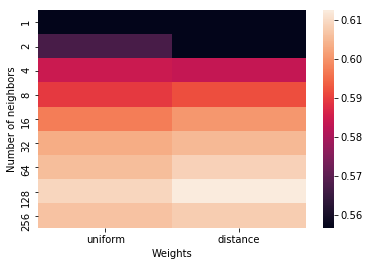

In [22]:
Xtraintemp,Xtesttemp,Ytraintemp, Ytesttemp = mo.train_test_split(xtrainsel, Ytrain, random_state=555953)
Ytraintemp=(Ytraintemp>1500)
Ytesttemp=(Ytesttemp>1500)
accuracies=[]
i=0
for nn in [1, 2, 4, 8, 16, 32, 64, 128, 256]:
    accuracies.append([])
    for weight in ['uniform', 'distance']:
        print("n_neighbors=", nn, " weights=", weight, end="\r")
        mod=neigh.KNeighborsClassifier(n_neighbors=nn, weights=weight)
        mod.fit(Xtraintemp,Ytraintemp)
        accuracies[i].append(mod.score(Xtesttemp,Ytesttemp))
    i=i+1
ax = sns.heatmap(accuracies, yticklabels=[1, 2, 4, 8, 16, 32, 64, 128, 256],  xticklabels=['uniform', 'distance'])
ax.set(xlabel='Weights', ylabel='Number of neighbors')

Vemos que ambos modelos tienen su mejor predicción en 128 vecinos. Sin embargo, es mejor siempre el peso ponderado por distancia al no ponderado, excepto en el caso de los dos vecinos más cercanos. 

**El mejor modelo, con base en las gráficas, parece ser Random Forest con 512 estimadores y profundidad de 16.** 

A continuación observaremos ese modelo a mayor detalle.

## 3.4 Random forest a mayor detalle: Selección de thresholds

Hemos elegido como mejor modelo a RF porque fue el que dió mayor precisión. Ahora lo veremos a mayor detalle. Para empezar, veremos cómo se comporta la curva ROC. Es importante porque nos da información acerca de cómo ir bajando el threshold de "popularidad" aumenta los falsos positivos pero también decrece los falsos negativos. 

In [78]:
Ytrain=(Ytrain>1500)
Ytest=(Ytest>1500)
mod=ens.RandomForestClassifier(n_estimators=512, max_depth=16, random_state=555953)
mod.fit(Xtrainst,Ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=512, n_jobs=1,
            oob_score=False, random_state=555953, verbose=0,
            warm_start=False)

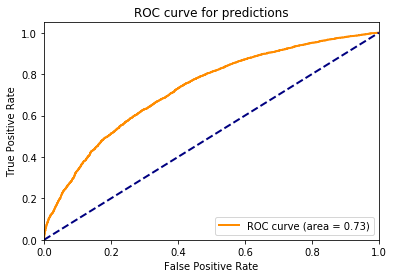

In [79]:
y_scoretup = mod.predict_proba(Xtestst)
y_score=[]
s=0
for ok in y_scoretup:
    y_score.append(ok[1])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(1):
    fpr[i], tpr[i], _ = roc_curve(Ytest, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Ytest.ravel(), y_score)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for predictions')
plt.legend(loc="lower right")
plt.show()

Con base en la curva podemos ver que un FPR de 50% logtamos un TPR cercano a 80%. A continuación damos más información de esta relación.

In [80]:
nextv=0.2
index=0
while nextv<1:
    while tpr[0][index]<nextv:
        index=index+1
    print("Para encontrar el ", round(nextv*100), "% más propenso a ser popular, un ", round(fpr[0][index]*100), "% de los negativos será confundido con popular")
    nextv=nextv+0.2

Para encontrar el  20 % más propenso a ser popular, un  5.0 % de los negativos será confundido con popular
Para encontrar el  40 % más propenso a ser popular, un  13.0 % de los negativos será confundido con popular
Para encontrar el  60 % más propenso a ser popular, un  27.0 % de los negativos será confundido con popular
Para encontrar el  80 % más propenso a ser popular, un  48.0 % de los negativos será confundido con popular


Ahora veremos, para distintos thresholds, qué porcentaje de lo predicho correctamente positivo será negativo; y qué porcentaje de las noticias serían clasificadas positivas

In [105]:
threshs=range(1000)
perc_pos=[]
perc_corr_pos=[]
xaxis=[]
for k in threshs:
    print(k, end="\r")
    k=k/1000
    y_pred_th=[i>k for i in y_score]
    if sum(y_pred_th)>0:
        xaxis.append(k)
        perc_pos.append(sum([i>k for i in y_score])/len(y_score))
        perc_corr_pos.append(precision_score(Ytest.ravel(), y_pred_th))

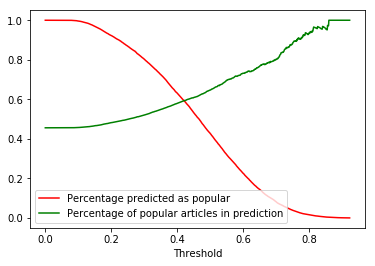

In [110]:
plt.plot(xaxis, perc_pos, color='red')
plt.plot(xaxis, perc_corr_pos, color='green')
plt.legend(['Percentage predicted as popular', 'Percentage of popular articles in prediction'])
plt.xlabel("Threshold")
plt.show()


Con base en la curva anterior, podemos ver que si la empresa quiere una mayor precisión en sus predicciones, puede mover el threshold de decisión para aumentarla. A continuación ejemlos:

In [122]:
nextv=0.1
index=0
while nextv<1 and index<len(xaxis):
    while xaxis[index]<nextv:
        index=index+1
        if index==len(xaxis):
            break
    if index!=len(xaxis):
        print("Con un threshold de ", round(xaxis[index]*100), "%:\nEl ", round(perc_pos[index]*100), "% de los artículos serán clasificados como populares. De esos, el ",round(perc_corr_pos[index]*100),"% lo serán realmente")
    nextv=nextv+0.1

Con un threshold de  10 %:
El  100.0 % de los artículos serán clasificados como populares. De esos, el  46.0 % lo serán realmente
Con un threshold de  20 %:
El  92.0 % de los artículos serán clasificados como populares. De esos, el  48.0 % lo serán realmente
Con un threshold de  30 %:
El  80.0 % de los artículos serán clasificados como populares. De esos, el  52.0 % lo serán realmente
Con un threshold de  40 %:
El  63.0 % de los artículos serán clasificados como populares. De esos, el  58.0 % lo serán realmente
Con un threshold de  50 %:
El  43.0 % de los artículos serán clasificados como populares. De esos, el  65.0 % lo serán realmente
Con un threshold de  60 %:
El  22.0 % de los artículos serán clasificados como populares. De esos, el  73.0 % lo serán realmente
Con un threshold de  70 %:
El  8.0 % de los artículos serán clasificados como populares. De esos, el  80.0 % lo serán realmente
Con un threshold de  80 %:
El  2.0 % de los artículos serán clasificados como populares. De esos,

Nosotros recomendaríamos un threshold de 60% o 50% dependiendo de las prioridades de la empresa. 

# 4 Utilización de la información

Hemos elegido el modelo ganador y otorgado el comportamiento de las predicciones para distintos thresholds. Sin embargo, queda la pregunta: ¿Cómo se usará el modelo para mejorar a la empresa? De entrada, saber la popularidad de una noticia de antemano es positivo. Así la empresa puede saber en qué invertir sus recursos para publicidad, por ejemplo. Sin embargo, buscamos utilizar este modelo para saber qué será lo mejor para cambiar las noticias no populares.

Hicimos una función que encuentra cuál métrica, siendo aumentada en (1/2) desviación estándar, ofrece mejor aumento en popularidad. Cada vez que se escribiera una noticia, se podrían ingresar sus parámetros en nuestro método $MejorarNoticia$ y se obtendrá la mejor variable para aumentar su probabilidad de popularidad. Posteriormente, probamos esto para 200 noticias al azar, para ver si hay parámetros que mejoren a todas las noticias de manera general. Si es el caso, esto daría ideas para implementar políticas dentro de la empresa.

In [179]:
triples=[]
for s in range(200):
    print(s, "/",200, end="\r" )
    triples.append(MejorarNoticia(pd.DataFrame(Xtestst.ix[s].values.reshape(1,-1), columns=Xtestst.keys()), mod))

In [194]:
pd.DataFrame(triples, columns=["Variable", "Cambio", "Signo"])[['Variable','Signo', 'Cambio']].groupby(["Variable", "Signo"]).agg(['mean','count'])

Cambio      
                                       mean count
Variable                    Signo                
 LDA_03                     -1     0.023126     1
 average_token_length       -1     0.055865     2
                             1     0.015868     1
 global_subjectivity        -1     0.015094     1
                             1     0.033943     3
 kw_avg_avg                  1     0.086388    47
 kw_avg_max                  1     0.016062     1
 kw_avg_min                  1     0.042614     6
 kw_max_avg                 -1     0.038357     1
                             1     0.090051    21
 kw_max_min                 -1     0.030501     1
                             1     0.033259     3
 kw_min_avg                  1     0.062199    12
 kw_min_max                  1     0.020731     1
 min_positive_polarity      -1     0.049449     1
 n_non_stop_unique_tokens   -1     0.060197     8
                             1     0.103452     1
 n_tokens_title              1     0.023750     1
 n_unique_tokens            -1     0.054244     8
 num_hrefs                   1     0.013541     2
 num_imgs                    1     0.038695     6
 num_self_hrefs              1     0.012703     1
 self_reference_avg_sharess  1     0.070439    21
 self_reference_max_shares   1     0.030542     4
 self_reference_min_shares   1     0.077737    42
 timedelta                  -1     0.054966     1
                             1     0.075641     3

La tabla anterior muestra cómo se distribuyen las mejores variables para aumentar popularidad. La primera columna denota qué variable se trata. La segunda denota si aumentar la probabilidad se logra aumentándola (1) o reduciéndola (-1) en media desviación estándar. Finalmente, aparece en promedio en cuánto aumentaría la popularidad de forma hipotética en promedio, y el número de artículos cuya popularidad aumenta al máximo al aumentar esa variable. Con base en la tabla, podemos inferir que lo ideal para mejorar un artículo es que el promedio de veces compartidas de las _keywords_ de un artículo (kw_avg_avg) sean más alto para 47 casos de 200. También ayuda que el mínimo de los artículos referenciados (self_reference_min_shares) sea más alto para 42 artículos.  

Lo anterior, puede dar cuenta de qué políticas puede implementar la empresa para construir sus artículos de tal forma que sean más veces compartidos en medios (populares).

# 5 Conclusión

Nosotros hemos visto que un modelo de Random forest con bastantes estimadores y algo de profundidad puede ser un buen predictor para la popularidad, medida como el número de veces que se comparte un artículo. Queda como trabajo futuro:

* Predecir artículos muy populares y muy impopulares
* Predecir la cantidad de veces que se comparte un artículo

El modelo que hicimos es muy versátil. Las prioridades de la empresa podrán definir cuál será el mejor threshold. Por ejemplo, si es menos costoso que un articulo sea pronosticado como no popular y en realidad sí lo sea (un falso positivo), la empresa puede poner el threshold más bajo. En sentido opuesto, si prefiere sólo predicciones seguras, lo puede poner muy alto. Aprendimos que hay variables que son la mejor variable (entre las 32 que usamos al final) para mejorar de forma muy común. Las recomendaciones que haríamos a la empresa con base en lo visto sería:
* Predcir la popularidad de los artículos. Con base en la probabilidad, otorgar más o menos publicidad a cada uno. 
* Dar prioridad a mejorar las métricas que vimos que son más importantes. 

# Referencias

K. Fernandes, P. Vinagre and P. Cortez. A Proactive Intelligent Decision Support System for Predicting the Popularity of Online News. Proceedings of the 17th EPIA 2015 - Portuguese Conference on Artificial Intelligence, September, Coimbra, Portugal.

Sasa Petrovic, Miles Osborne, and Victor Lavrenko. RT to Win! Predicting Message
Propagation in Twitter. In Fifth International AAAI Conference on Weblogs and Social Media (ICWSM), pages 586–589, 2011.

Elena Hensinger, Ilias Flaounas, and Nello Cristianini. Modelling and predicting
news popularity. Pattern Analysis and Applications, 16(4):623–635, 2013